In [118]:
import sys, importlib
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, util
import numpy as np
import numpy.typing as npt
from typing import List
import random as rand
import math
from scripts.classes import Label, Sample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score
importlib.reload(sys.modules['scripts'])

TRAIN_DATA = "../data/EuroSatData/train.csv"
TEST_DATA = "../data/EuroSatData/test.csv"
VALIDATION_DATA = "../data/EuroSatData/validation.csv"


In [59]:
train_df = pd.read_csv(TRAIN_DATA)
train_df["Filename"] = "../data/EuroSatData/" + train_df["Filename"].astype(str)
test_df = pd.read_csv(TEST_DATA)
test_df["Filename"] = "../data/EuroSatData/" + test_df["Filename"].astype(str)
validation_df = pd.read_csv(VALIDATION_DATA)
validation_df["Filename"] = "../data/EuroSatData/" + validation_df["Filename"].astype(str)
all_data_df = pd.concat([train_df, test_df, validation_df], axis=0)

label_counts = all_data_df.value_counts("ClassName")

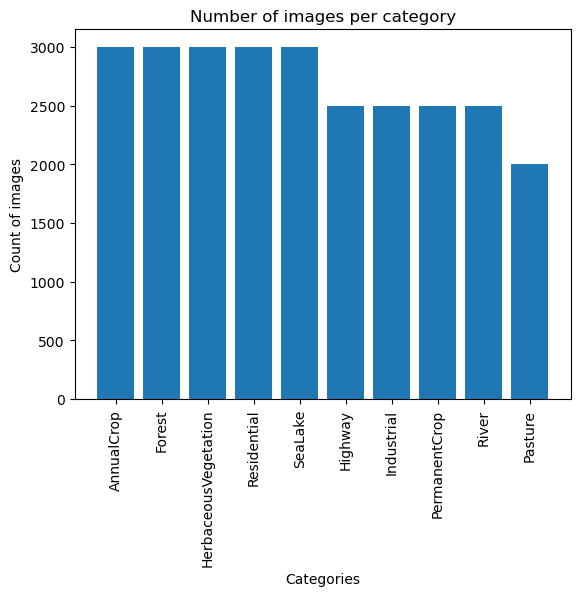

In [60]:
# Dataset Figure
labels = list(label_counts.keys())
counts = label_counts.values
plt.bar(labels, counts)
plt.title("Number of images per category")
plt.ylabel("Count of images")
plt.xticks(labels)
plt.xticks(rotation = 90)
plt.xlabel("Categories")
plt.show()

In [5]:
# Data Sample Figure
def read_img(path):
  return util.img_as_float64(io.imread(path))

test_path = "../data/EuroSatData/River/River_64.jpg"
samples = train_df.sample(9)
samples = samples.drop(["ClassName", "Unnamed: 0"], axis=1)
samples["Image"] = samples["Filename"].apply(read_img)


In [61]:
samples_list = Sample.reading_list(samples)
samples_list

[Image name: ../data/EuroSatData/HerbaceousVegetation/HerbaceousVegetation_31.jpg | Label: 2,
 Image name: ../data/EuroSatData/Pasture/Pasture_422.jpg | Label: 5,
 Image name: ../data/EuroSatData/Highway/Highway_238.jpg | Label: 3,
 Image name: ../data/EuroSatData/Residential/Residential_2817.jpg | Label: 7,
 Image name: ../data/EuroSatData/River/River_48.jpg | Label: 8,
 Image name: ../data/EuroSatData/Forest/Forest_2181.jpg | Label: 1,
 Image name: ../data/EuroSatData/SeaLake/SeaLake_2683.jpg | Label: 9,
 Image name: ../data/EuroSatData/PermanentCrop/PermanentCrop_1794.jpg | Label: 6,
 Image name: ../data/EuroSatData/HerbaceousVegetation/HerbaceousVegetation_2204.jpg | Label: 2]

In [25]:
def plot_image(ax, img: npt.NDArray[np.float64], name: str):
  ax.imshow(img)
  img_name = name.split("/")[2]
  ax.set_title(img_name)

def display_images(sample_list: List[Sample], rows, columns):
  _, ax = plt.subplots(rows, columns, figsize=(16, 18))
  for r in range(rows):
    for c in range(columns):
      index = (r * columns) + c
      sample = sample_list[index]
      plot_image(ax[r][c], sample.img_array, sample.img_name)

[Image name: ../data/EuroSatData/Pasture/Pasture_1275.jpg | Label: 5,
 Image name: ../data/EuroSatData/Forest/Forest_1451.jpg | Label: 1,
 Image name: ../data/EuroSatData/SeaLake/SeaLake_377.jpg | Label: 9,
 Image name: ../data/EuroSatData/Forest/Forest_634.jpg | Label: 1,
 Image name: ../data/EuroSatData/Residential/Residential_2099.jpg | Label: 7,
 Image name: ../data/EuroSatData/PermanentCrop/PermanentCrop_1808.jpg | Label: 6,
 Image name: ../data/EuroSatData/Highway/Highway_1984.jpg | Label: 3,
 Image name: ../data/EuroSatData/PermanentCrop/PermanentCrop_1831.jpg | Label: 6,
 Image name: ../data/EuroSatData/Pasture/Pasture_459.jpg | Label: 5]

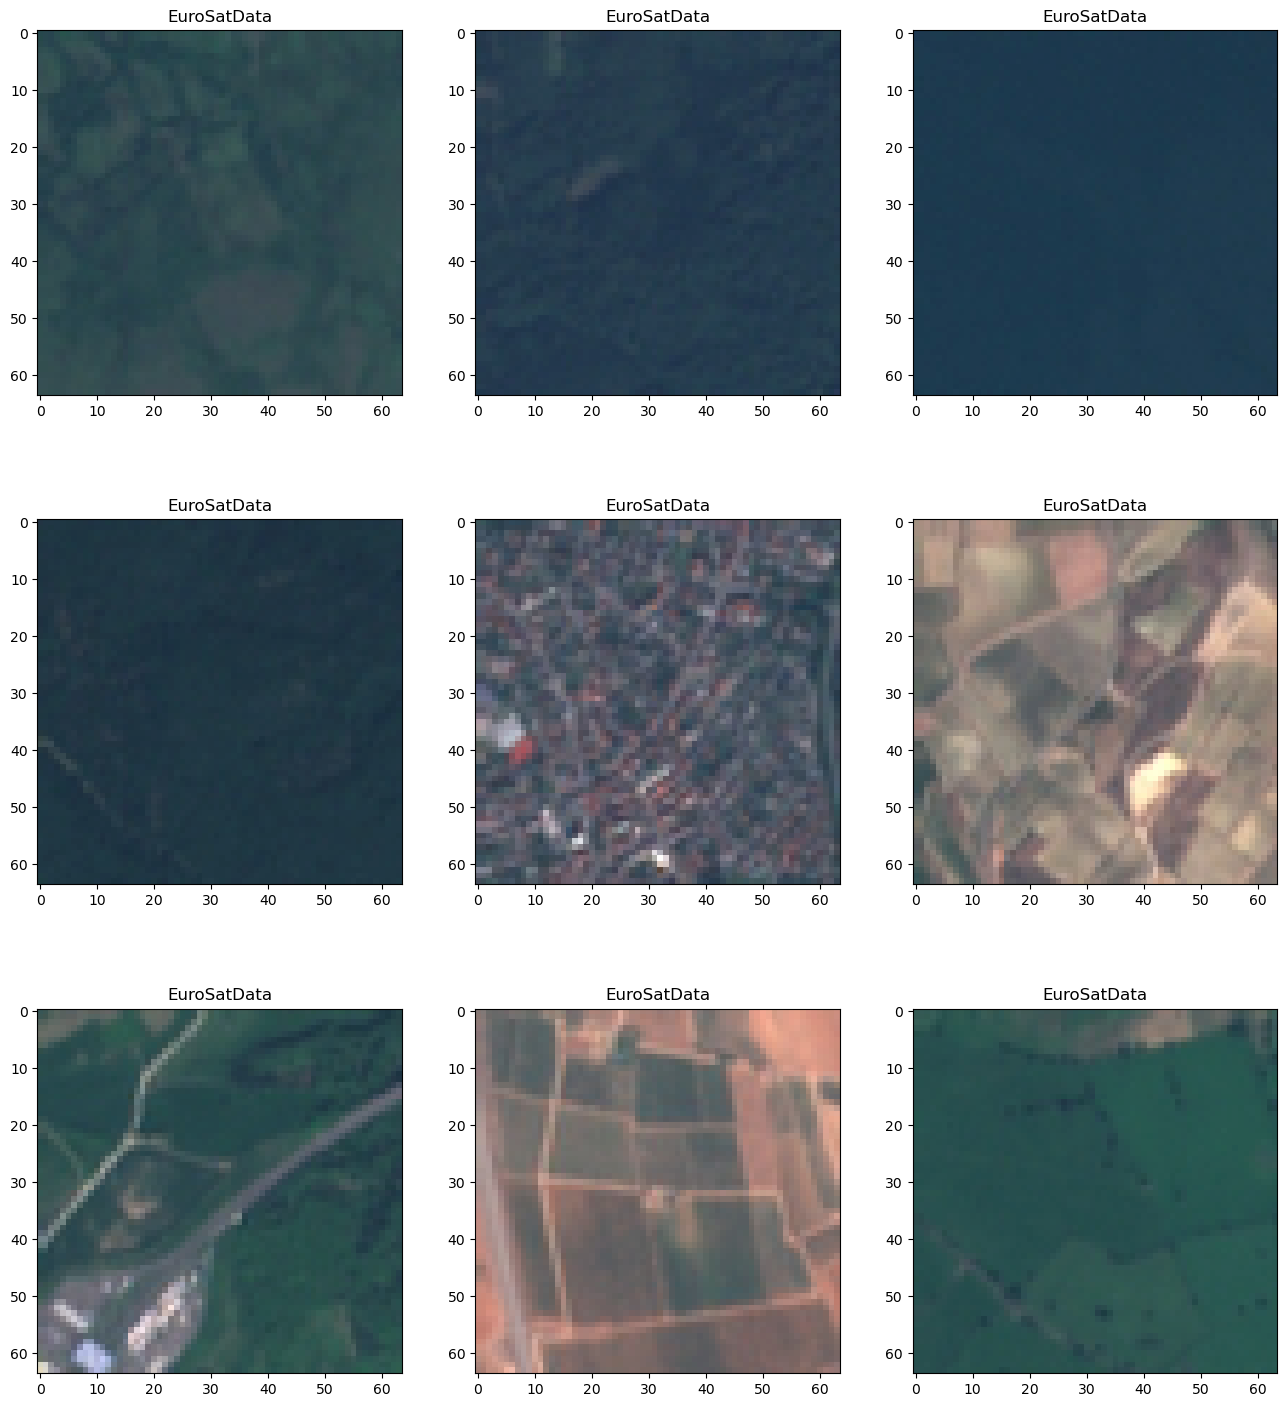

In [29]:
display_images(samples_list, 3, 3)
samples_list

In [66]:
# Proposed Results figure - Fake Data
def fake_exp_data(x_range, exp_range, uniform_variation, neg=False):
  rand_exp = rand.uniform(exp_range[0], exp_range[1])
  rand_exp = -1*rand_exp if neg else rand_exp
  return [(i + rand.uniform(uniform_variation[0], uniform_variation[1]))**rand_exp for i in x_range]

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def fake_acc_data(x_range, exp_range, uniform_variation, root):
  rand_exp = rand.uniform(exp_range[0], exp_range[1])
  max_val = x_range[1]
  accuracy = []
  for i in x_range:
    numerator = i + rand.uniform(uniform_variation[0], uniform_variation[1])
    value = (numerator/max_val)**rand_exp
    accuracy.append(sigmoid(value)**(root))
  return accuracy

In [31]:
# Fake loss values
train_loss = fake_exp_data(range(15), (0.8, 1), (5, 10), True)
validation_loss = fake_exp_data(range(15), (0.8, 1), (5, 10), True)


In [48]:
# Fake accuracy values
train_accuracy = fake_acc_data(x_range=range(15, 30), exp_range=(3, 5), uniform_variation=(15, 20), root=1/6)
validation_accuracy = fake_acc_data(x_range=range(15, 30), exp_range=(3, 5), uniform_variation=(15, 18), root=1/6)

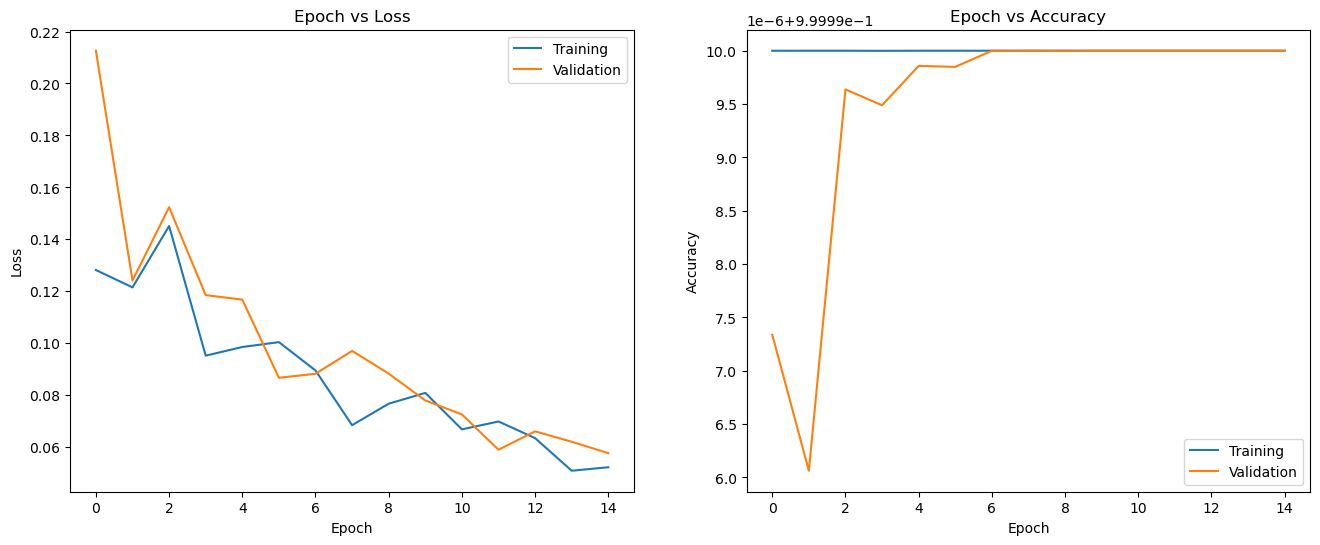

In [49]:

plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.plot(validation_loss)
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"])

plt.show()


In [188]:
def fake_confusion_matrix(true_positive_chance):
  assert true_positive_chance <= 1 and true_positive_chance > 0
  y_test = test_df["ClassName"]
  predicted = []
  all_labels = Label.all_labels()

  for actual in y_test:
    chance = rand.uniform(0, 1)
    if chance <= true_positive_chance:
      predicted.append(actual)
    else:
      predict = rand.choice(all_labels)
      while predict == actual:
        predict = rand.choice(all_labels)
      predicted.append(predict)
    
  return y_test, pd.Series(predicted)

def plot_recall_precision(ax, precision_score, recall_score):
  y_bar = [round(precision_score*100, 3), round(recall_score*100, 3)]
  ax.bar(["Precision", "Recall"], y_bar, width=0.8)
  ax.set_ylim(0,100)
  ax.set_title("Precision and Recall score")
  ax.set_ylabel("Percentage")
  ax.set_xlabel("Precision and Recall")
  xlocs, _ = plt.xticks()
  for i, v in enumerate(y_bar):
    ax.text(xlocs[i] - 0.25, v + 0.01, str(v))

In [173]:
# Fake Confusion Matrix Vaues
TRUE_POSITIVE_PERCENTAGE = 0.9
y_test, predicted_values = fake_confusion_matrix(TRUE_POSITIVE_PERCENTAGE)

In [174]:
matrix = confusion_matrix(y_test, predicted_values)
p_score = precision_score(y_true=y_test, y_pred=predicted_values, average="micro")
r_score = recall_score(y_true=y_test, y_pred=predicted_values, average="micro")

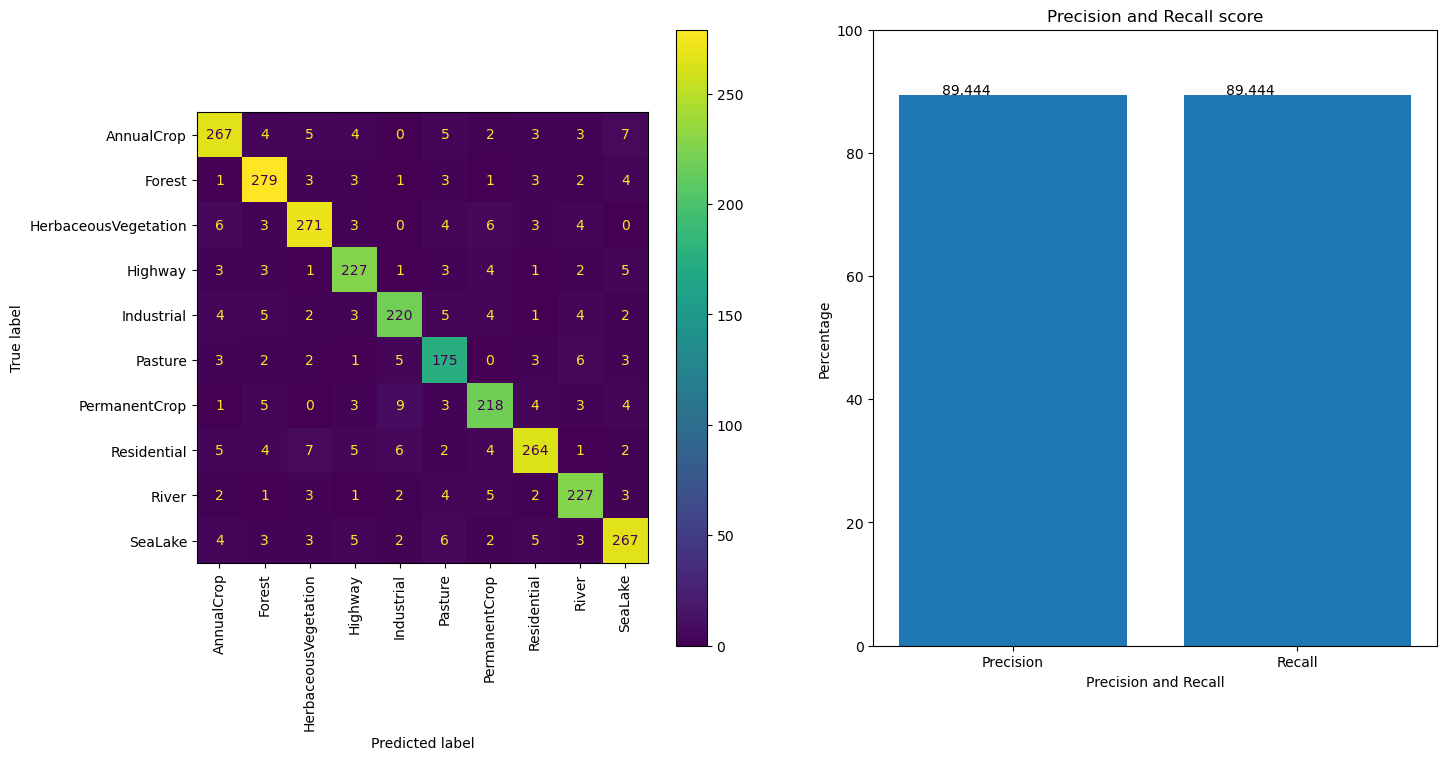

In [189]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
ConfusionMatrixDisplay.from_predictions(y_test, predicted_values, labels=Label.all_labels(), xticks_rotation="vertical", ax=axes[0])
plot_recall_precision(axes[1], p_score, r_score)
